In [148]:
import tweepy
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import json
from tweepy import Stream
import csv
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from datetime import datetime#
import pymongo
import ipywidgets as wgt
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
import re

pd.options.display.max_columns = 50
pd.options.display.max_rows = 50
pd.options.display.width = 120


# The goal of this code is to generate market response of each geographical area based on tweets search and company related key words.

### The '2' represents the salesman.
### The '1' represents the best response.
### The '-1' represents the worst response.
### Suppose the salesman begins at (lat, long) = (37.33, -121.89) (within Bay Area)
### lat_shift = 0.02 degree
### long_shift = 0.02 degree
### step = 1
### We use matrix to represent response geographical distribution and assme that the salesman begins at position [0, 0] at matrix. Following matrix shows that the best response is at the position [1, 2] which corresponds to two steps toward east and one step toward south, i.e., (lat, long) = (37.33 - 1 $\times$ 0.02, -121.89 + 2 $\times$ 0.02) = (37.31, -121.85). Simiarly, the worst response is at the position [2, 1] which corresponds to two steps toward south and one step toward east, i.e., (lat, long) = (37.33 - 2 $\times$ 0.02, -121.89 + 1 $\times$ 0.02) = (37.29, -121.87).

tweets_market = [[ 2,   0,  0],
                 [ 0,   0,  1],
                 [ 0,  -1,  0 ]]



# Tweeter Account Credential

In [149]:


consumer_key = "Your key"

consumer_secret = "Your secret";

access_token = "Your token";

access_token_secret = "Your token secret";


auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth)

# Positive and Negative words in marketing
### We created the positive and negative words dictionary by using marketing specific context words  
### suggested by McDonald’s research http://www3.nd.edu/~mcdonald/Word_Lists.html. 
### In this dictionary, we collected 2360 positive words stored in positive_words.txt file
### and 7383 negative words stored in negative_words.txt file. 

In [150]:
# Few positive words 

LINE_COUNT = 5
print("Positive Words: ")
print([s for (i, s) in enumerate(open('positive_words.txt')) if i < LINE_COUNT])

# Few negative words 

LINE_COUNT = 5
print("Negative Words: ")
print([s for (i, s) in enumerate(open('negative_words.txt')) if i < LINE_COUNT])


Positive Words: 
['ABLE\n', 'ABUNDANCE\n', 'ABUNDANT\n', 'ACCLAIMED\n', 'ACCOMPLISH\n']
Negative Words: 
['ABANDON\n', 'ABANDONED\n', 'ABANDONING\n', 'ABANDONMENT\n', 'ABANDONMENTS\n']


In [151]:

# Following codes provide verification a given word is positive or negative

def is_positive(word):
    with open('positive_words.txt') as f:
        found = False
        for line in f:
            if word.upper() in line: # Key line: check if `w` is in the line.
                found = True
                return found 
            else:
                continue
        return False
    
def is_negative(word):
    with open('negative_words.txt') as f:
        found = False
        for line in f:
            if word.upper() in line: # Key line: check if `w` is in the line.
                found = True
                return found 
            else:
                continue
        return False
    
# Evaluate tweets score accoding to positive words and negative words dictionary
# Final score is the positive words count minus negative words count divided by total words count represented 
# by percentage
    
def text_score(tweets):
    wordList = re.sub("[^\w]", " ",  tweets).split()
    positive_count = 0
    negative_count = 0
    su = 0
    for word in wordList: 
        su = su + 1 
        if word.isalpha() and (is_positive(str(word))):
            positive_count = positive_count + 1
        elif word.isalpha() and (is_negative(str(word))):
            negative_count = negative_count + 1      
        else:
            continue
    return (float(positive_count - negative_count)/float(su)) * 100 
    
    




In [167]:
#### Market Response Generation Function Most Recent

def Market_Response_Gen_Func(init_lat, init_long, lat_shift, long_shift, tweets_count, step_size, total_steps, query):

    for i in range(0, total_steps):
        for j in range(0, total_steps):
            if ((i + j) != 0):
                geo = str(init_lat + step*i*lat_shift) + "," + str(init_long + step*j*long_shift) + ",7km"
                results = api.search(q = query, count = tweets_count, geocode=geo) 
                if len(results) != 0: 
                    score_sum = 0
                    for k in range(0, len(results)):
                        d = results[k].text
                        score_sum += text_score(d)
                    score_list[i*total_steps + j] = float(score_sum)/float(tweets_count)
                else:
                    score_list[i*total_steps + j] = -1
            else:
                score_list[0] = 2
    # Because the first position of score_list is to save salseman 
    # To get tweets_market matrix
    max_score_list = max(score_list[1:])
    min_score_list = min(score_list[1:])
    tweets_market = [[0 for x in range(total_steps)] for y in range(total_steps)] 

    for i in range(0, total_steps):
        for j in range(0, total_steps):
            tmp = score_list[i*total_steps + j] 
            if ((i + j) == 0):
                tweets_market[i][j] = 2
            else:
                if (tmp == max_score_list):
                    tweets_market[i][j] = 1
                if (tmp == min_score_list):
                    tweets_market[i][j] = -1          
        
    return tweets_market
    
    ## Bay Area
init_lat = 37.33
init_long = -121.89
lat_shift = 0.02
long_shift = 0.02
tweets_count = 10
step_size = 1
total_steps = 3
score_list = [0] * (total_steps ** 2)
query = 'IBM' 


print(Market_Response_Gen_Func(init_lat, init_long, lat_shift, long_shift, tweets_count, \
                               step_size, total_steps, query))  

tweets_market = Market_Response_Gen_Func(init_lat, init_long, lat_shift, long_shift, tweets_count, \
                               step_size, total_steps, query)


[[2, 1, 1], [1, 1, 0], [0, 0, -1]]


## Plotting market response by color diagram

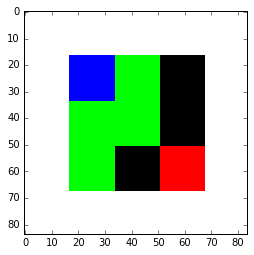

In [169]:
%matplotlib inline

import gym
import itertools
import numpy as np
import os
import random
import sys
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy.misc



if "../" not in sys.path:
  sys.path.append("../")

from reinforcement_denny_lib import plotting
from collections import deque, namedtuple
from salesman import salesEnv
import random
import matplotlib.pyplot as plt




env = salesEnv(partial=False, size=len(tweets_market), coor=tweets_market)

## Market Response with Time Range and associated color diagram

In [185]:
#### Market Response Generation Function with Time Range

def Market_Response_Gen_Func_Time(init_lat, init_long, lat_shift, long_shift, tweets_count, step_size, total_steps,\
                             time_begin, time_end, query):

    for i in range(0, total_steps):
        for j in range(0, total_steps):
            if ((i + j) != 0):
                geo = str(init_lat + step*i*lat_shift) + "," + str(init_long + step*j*long_shift) + ",7km"
                results = api.search(q = query, count = tweets_count, since = time_begin, until = time_end, geocode=geo) 
               
                if len(results) != 0: 
                    score_sum = 0
                    for k in range(0, len(results)):
                        d = results[k].text
                        score_sum += text_score(d)
                    score_list[i*total_steps + j] = float(score_sum)/float(tweets_count)
                else:
                    score_list[i*total_steps + j] = -1
            else:
                score_list[0] = 2
    # Because the first position of score_list is to save salseman 
    # To get tweets_market matrix
    max_score_list = max(score_list[1:])
    min_score_list = min(score_list[1:])
    tweets_market = [[0 for x in range(total_steps)] for y in range(total_steps)] 

    for i in range(0, total_steps):
        for j in range(0, total_steps):
            tmp = score_list[i*total_steps + j] 
            if ((i + j) == 0):
                tweets_market[i][j] = 2
            else:
                if (tmp == max_score_list):
                    tweets_market[i][j] = 1
                if (tmp == min_score_list):
                    tweets_market[i][j] = -1          
        
    return tweets_market
    
    ## Bay Area
init_lat = 37.33
init_long = -121.89
lat_shift = 0.02
long_shift = 0.02
tweets_count = 10
step_size = 1
total_steps = 3
score_list = [0] * (total_steps ** 2)
query = 'Apple Inc' 

time_begin="2017-01-20",
time_end="2017-01-23"

print(Market_Response_Gen_Func_Time(init_lat, init_long, lat_shift, long_shift, tweets_count, \
                               step_size, total_steps, time_begin, time_end, query))  



tweets_market = Market_Response_Gen_Func_Time(init_lat, init_long, lat_shift, long_shift, tweets_count, \
                               step_size, total_steps, time_begin, time_end, query)


[[2, 0, -1], [0, 0, 0], [0, -1, 1]]


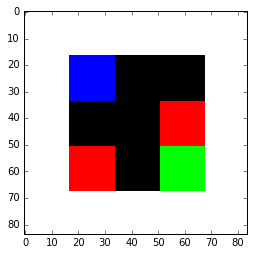

In [186]:
##### Plotting market response by color diagram

env = salesEnv(partial=False, size=len(tweets_market), coor=tweets_market)

## Tweets marketing response at each region near Bay Area (latitude = 37.33,  longitude = -121.89). Each sub-square is a region with size 10^2 square miles. The green region is the area with positive tweets response for query "Apple Inc." between dates 2017-01-20 and 2017-01-23.  The red region is the area with negative tweets response for query "Apple Inc." between dates 2017-01-20 and 2017-01-23. The black region is the area with neutral tweets response for same query and time period. The goal for a salesman is to move from the blue sub-square to the green one while avoiding the red ones. 